In [1]:
import pyvista as pv
from Kirchhoffpy import lenspy
from Kirchhoffpy import Feedpy
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from Kirchhoffpy import coordinate,field_storage
from Kirchhoffpy.Vopy import CO,dotproduct,abs_v
c=299792458
p = pv.Plotter()
srffolder = 'srf/'


In [2]:
# 1. define frequnecy and wavelength
freq = 150*10**9
Lambda = c*1000/freq
k = 2*np.pi/Lambda
print(Lambda,k)


1.9986163866666666 3.1437675329275225


In [3]:
# 2. define coordinate systems
eff_focal_length = 569.56 #mm
coord_ref = coordinate.coord_sys([0,0,0],[0,0,0],axes = 'xyz')

coord_L1 = coordinate.coord_sys([0,0,-(803.9719951339465-4.34990822154231*10)],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)
coord_L2 = coordinate.coord_sys([0,0,-(227.64396727901004-4.696706712699847*10)],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)
coord_L3 = coordinate.coord_sys([0,0,-(71.77590111674095-2.96556*10)],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_feed_offset = coordinate.coord_sys([90,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)
coord_feed_rotation = coordinate.coord_sys([0,0,0],[0,0,0],axes = 'xyz',ref_coord = coord_feed_offset)
coord_feed = coordinate.coord_sys([0,0,0],[0,0,0],axes = 'xyz',ref_coord = coord_feed_rotation)



coord_sky_ref = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)
coord_sky = coordinate.coord_sys([0,0,0],[0,-90/569.56,0],axes = 'xyz',ref_coord = coord_sky_ref)


In [4]:
# 3. define input Feedhorn
feed= Feedpy.GaussiBeam(-2.1714724,
                        10.1161095,
                        k,
                        coord_feed,
                        polarization = 'x')


26584903304305.848


In [5]:
# 4. Lenses and aperture 
outputfolder = 'output2/150GHz/x90_offaxis_TEST/'
L1 = lenspy.simple_Lens(3.36,
                        4.34991*10,# Thickness
                        44.8*10, # diameter
                        srffolder + 'lens1_f2.rsf', 
                        srffolder + 'lens1_f1.rsf',
                        p,
                        coord_L1,
                        name = 'L1',
                        outputfolder = outputfolder)
L2 = lenspy.simple_Lens(3.36,
                        4.69671*10,# Thickness
                        44.8*10, # diameter
                        srffolder + 'lens2_f2.rsf', 
                        srffolder + 'lens2_f1.rsf',
                        p,
                        coord_L2,
                        name = 'L2',
                        outputfolder = outputfolder)

L3 = lenspy.simple_Lens(3.36,
                        2.96556*10,# Thickness
                        44.8*10, # diameter
                        srffolder + 'lens3_f2.rsf', 
                        srffolder + 'lens3_f1.rsf',
                        p,
                        coord_L3,
                        name = 'L3',
                        outputfolder = outputfolder)
#L2 = lenspy.simple_Lens(2,46.9671 ,400, srffolder + 'lens2_f1.rsf', srffolder + 'lens2_f2.rsf',p,[0,0,-227.64396727901004],name = 'L2')
#L3 = lenspy.simple_Lens(2,29.6556 ,400, srffolder + 'lens3_f1.rsf', srffolder + 'lens3_f2.rsf',p,[0,0,-71.77590111674095],name = 'L3')


In [6]:
# 5. fiedl storage
center_grd = field_storage.Spherical_grd(coord_sky,
                                         0,
                                         0,
                                         20,
                                         20,
                                         501,501,
                                         Type = 'ELoverAz', 
                                         far_near = 'far',
                                         distance = 50000)


In [7]:
#N1 =[760,1880]
#N2 = [480,2160]
N1 =[720,2160]
N2 = [350,2240]
L3.PO_analysis(#[400,1,400,1],
               [1,N1[0],N1[1],1],
               [1,N2[0],N2[1],1],
               #[5,N2[0],N2[1],1],
            feed,k,
            sampling_type_f1='polar',
            phi_type_f1 = 'less',
            sampling_type_f2='polar',
            phi_type_f2 = 'less',
            po_name = '_po_cur_0mm.h5',
            Method ='POPO')


Gain of the Guassian feedhonr!
-6.631975905905926 dB
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
input power
poynting value max!
0.002770720117815049
13.014576679252004
******
(array([], dtype=int64),)
test vx
1.0000000000000004 0.9999999999999994
Batch size: 43


100%|██████████| 11640/11640 [44:51<00:00,  4.33it/s]


(array([], dtype=int64),)
test vx
1.0000000000000004 0.9999999999999994
Transform f1
poynting value max!
0.0019451951708986971
8.672619749979134
f2
poynting value max!
0.0014218554671575224
8.874728371196946
f2 transmission
poynting value max!
6.3828525850852635


In [8]:
N1 =[2960 ,2440]
N2 = [620,640]
L2.PO_analysis(#[400,1,400,1],
               [1,N1[0],N1[1],1],
               [1,N2[0],N2[1],1],
               #[5,N2[0],N2[1],1],
            L3,k,
            sampling_type_f1='polar',
            phi_type_f1 = 'less',
            sampling_type_f2='polar',
            phi_type_f2 = 'less',
            po_name = '_po_cur_0mm.h5',
            Method ='POPO')


output2/150GHz/x90_offaxis_TEST/L3_po_cur_0mm.h5
Here
Batch size: 84


100%|██████████| 54867/54867 [3:23:47<00:00,  4.49it/s]  


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
input power
poynting value max!
0.0001296220725771473
6.48994447198158
******
(array([], dtype=int64),)
test vx
1.0000000000000004 0.9999999999999994
Batch size: 9


100%|██████████| 28323/28323 [1:50:58<00:00,  4.25it/s]


(array([], dtype=int64),)
test vx
1.0000000000000004 0.9999999999999994
Transform f1
poynting value max!
9.159595167717383e-05
4.401306485637206
f2
poynting value max!
7.533962503814732e-05
4.443206456060225
f2 transmission
poynting value max!
3.18757319343848


In [9]:
N1 =[680,2360]
N2 = [610,305]
L1.PO_analysis(#[400,1,400,1],
               [1,N1[0],N1[1],1],
               [1,N2[0],N2[1],1],
               #[5,N2[0],N2[1],1],
            L2,k,
            sampling_type_f1='polar',
            phi_type_f1 = 'less',
            sampling_type_f2='polar',
            phi_type_f2 = 'less',
            po_name = '_po_cur_0mm.h5',
            Method ='POPO')


output2/150GHz/x90_offaxis_TEST/L2_po_cur_0mm.h5
Here
Batch size: 169


100%|██████████| 6060/6060 [22:40<00:00,  4.45it/s]


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
input power
poynting value max!
5.253262608576319e-06
2.9831702671848594
******
(array([], dtype=int64),)
test vx
1.0000000000000004 0.9999999999999994
Batch size: 42


100%|██████████| 2873/2873 [11:09<00:00,  4.29it/s]


(array([], dtype=int64),)
test vx
1.0000000000000004 0.9999999999999994
Transform f1
poynting value max!
3.645821023695445e-06
2.0602410660100046
f2
poynting value max!
3.574893892642156e-06
2.0667326442973786
f2 transmission
poynting value max!
1.4730285686865534


In [10]:
center_grd.grid.x = center_grd.grid.x.ravel()
center_grd.grid.y = center_grd.grid.y.ravel()
center_grd.grid.z = center_grd.grid.z.ravel()
print(center_grd.grid.z.size)


251001


In [11]:
L1.source(center_grd,
          k,
          far_near = 'far')


output2/150GHz/x90_offaxis_TEST/L1_po_cur_0mm.h5
[[ 9.87541315e-01  3.39444784e-34  1.57359941e-01]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-1.57359941e-01 -1.02088256e-32  9.87541315e-01]]
*(**)
cores: 484


100%|██████████| 518/518 [00:50<00:00, 10.29it/s]


In [12]:
r, theta, phi = center_grd.coord_sys._toSpherical(center_grd.grid.x,center_grd.grid.y,center_grd.grid.z)
co,cx,crho = CO(theta,phi)
E_co = dotproduct(center_grd.E,co)
E_cx = dotproduct(center_grd.E,cx)


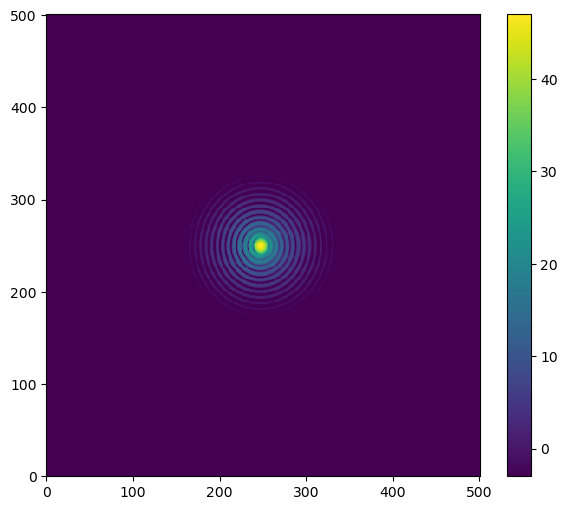

In [13]:
fig = plt.figure(figsize = (7,6))
vmax= np.log10(np.abs(E_co.reshape(501,-1)).max())*20
plt.pcolor(np.log10(np.abs(E_co.reshape(501,-1)))*20,vmax = vmax, vmin = vmax-50)
plt.colorbar()


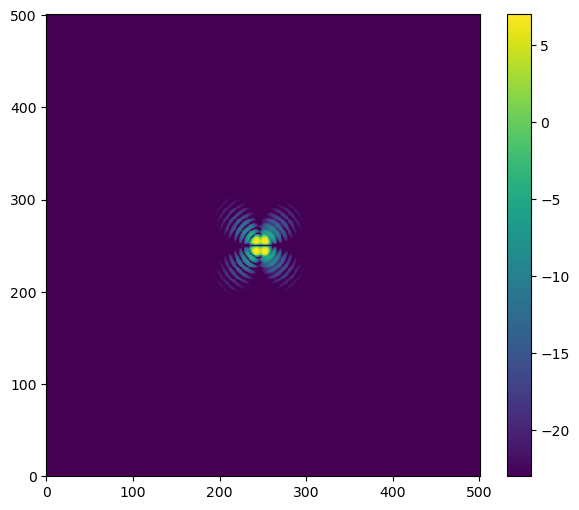

In [14]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_cx.reshape(501,-1)))*20,vmax = vmax-40, vmin = vmax-70)
plt.colorbar()


In [15]:
import h5py as h5
def readh5(fname):
    name = fname.split('.')
    with h5.File(name[0]+'.h5','r') as f:
        co = f['co-polar'][:,:]
        cx = f['cx-polar'][:,:]
        Az = f['Az'][:]
        El = f['El'][:]
    return Az, El, co, cx


In [16]:
Az, El, grasp_co,grasp_cx = readh5('output2/150GHz/150GHz_test/_H5/_x90_y0GHz.h5')


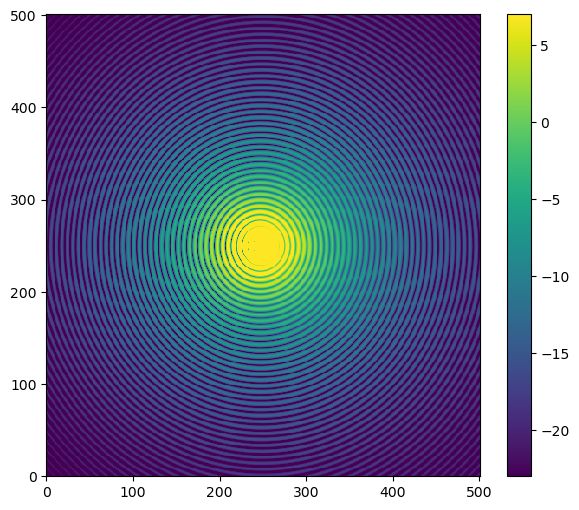

In [17]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_co.reshape(501,-1)))*20,vmax = vmax-40, vmin = vmax-70)
plt.colorbar()


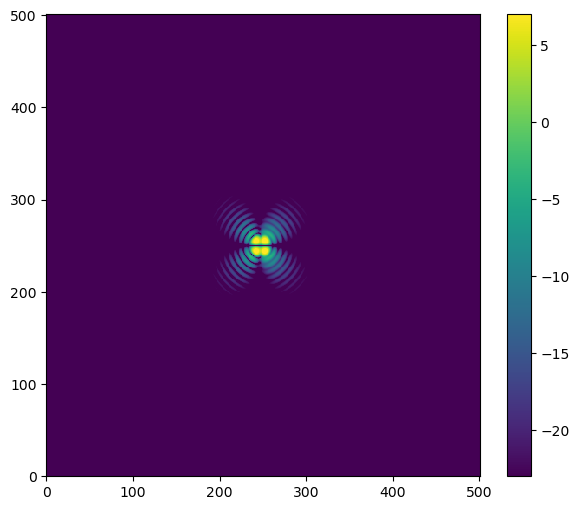

In [18]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_cx.reshape(501,-1)))*20,vmax = vmax-40, vmin = vmax-70)
plt.colorbar()


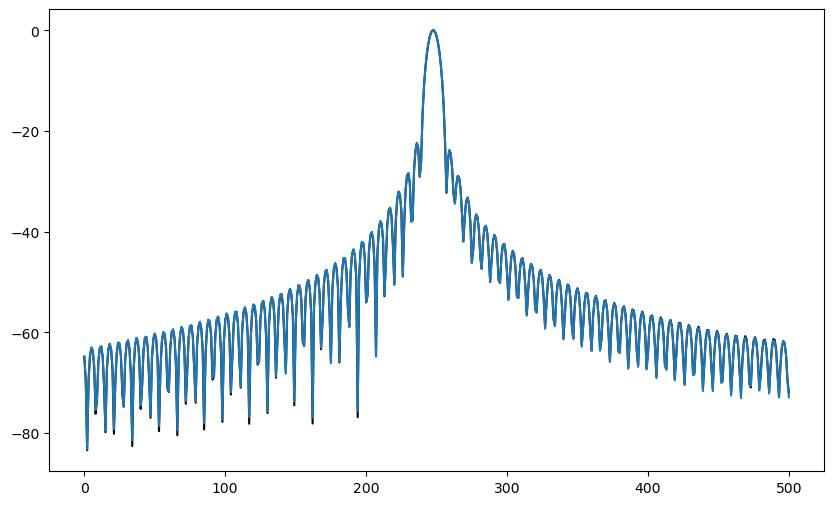

In [19]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:])/np.abs(grasp_co.reshape(501,-1)[250,:]).max())*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])/np.abs(E_co.reshape(501,-1)[250,:]).max())*20,'-')


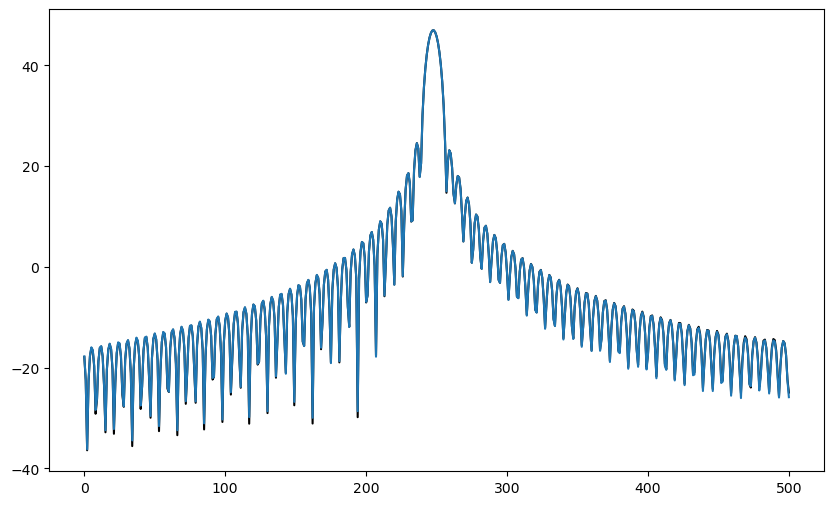

In [20]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')


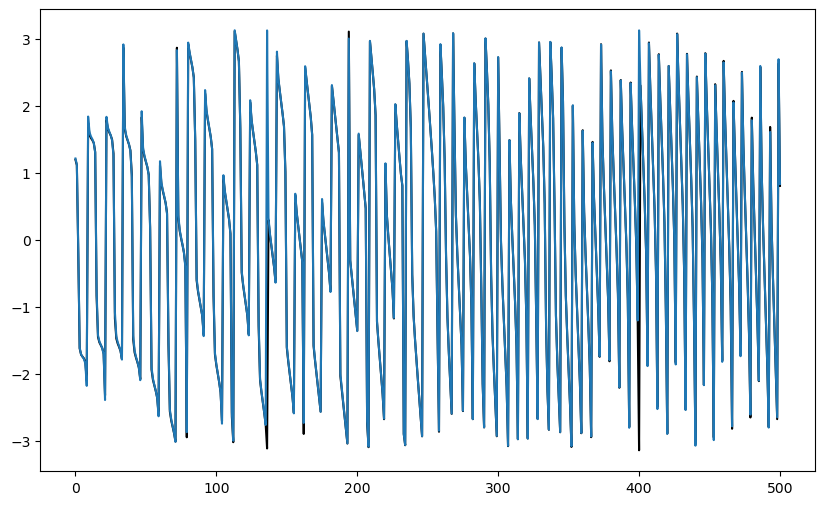

In [21]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.angle(grasp_co.reshape(501,-1)[250,:]/np.abs(grasp_co.reshape(501,-1)[250,:]).max()),'k-')
plt.plot(np.angle(E_co.reshape(501,-1)[250,:]/np.abs(E_co.reshape(501,-1)[250,:]).max()),'-')


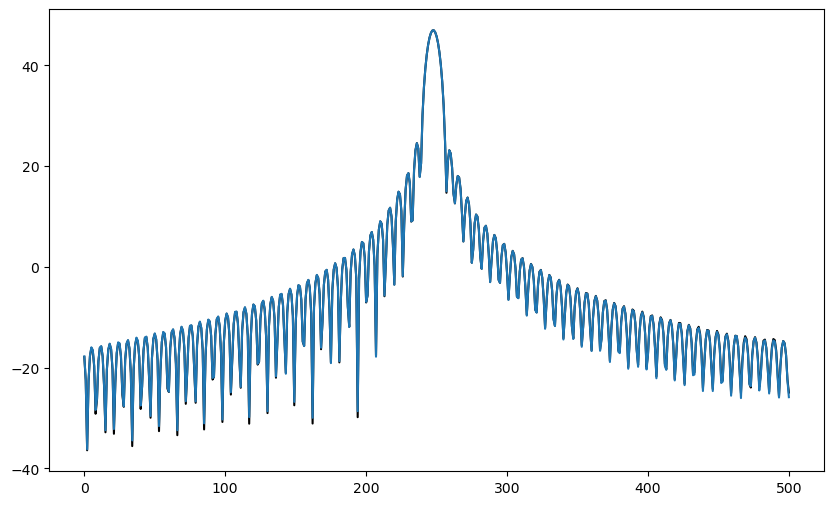

In [22]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')


In [36]:
G_co = grasp_co.reshape(501,-1)/grasp_co.reshape(501,-1)[250,250]
H_co = E_co.reshape(501,-1)/E_co.reshape(501,-1)[250,250]
err = H_co-G_co


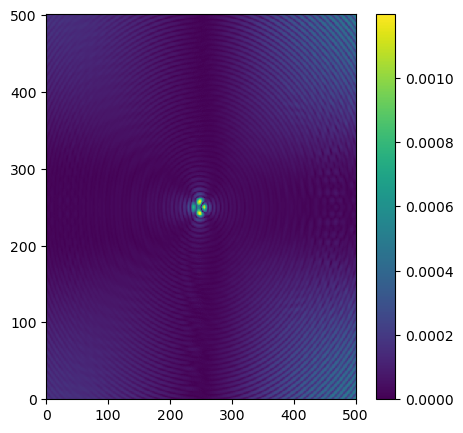

In [37]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()


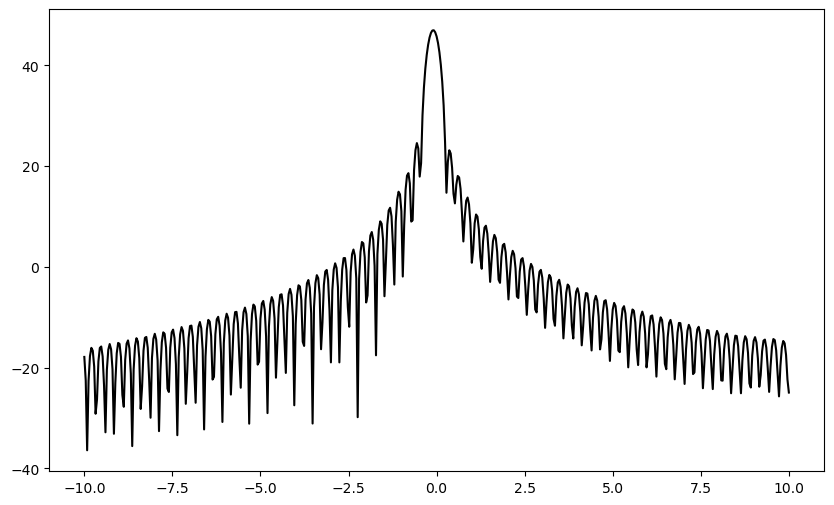

In [35]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(Az,np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')


(-1.0, 1.0)

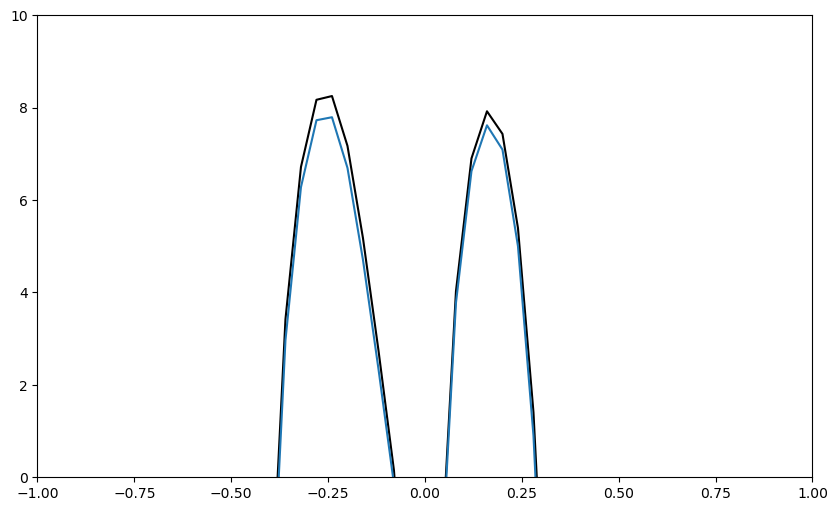

In [34]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(Az,np.log10(np.abs(np.diagonal(grasp_cx.reshape(501,-1))))*20,'k-')
plt.plot(Az,np.log10(np.abs(np.diagonal(center_grd.E.y.reshape(501,-1))))*20,'-')
plt.ylim([0,10])
plt.xlim(-1,1)


In [32]:
L_lensFp_3   = 7.177590111674096
L_lens3_2    = 15.586806616226909
L_lens2_1    = 57.632802785493645
L_lens1_Lyot = 1.162050628144469
L_Ly_vw      = 22.7114

L_lens1_ref = L_lensFp_3 + L_lens3_2 + L_lens2_1
L_lens2_ref = L_lensFp_3 + L_lens3_2
L_lens3_ref = L_lensFp_3 
L_Ly_ref = L_lens1_ref + L_lens1_Lyot
L_vw_ref = L_Ly_ref + L_Ly_vw


In [ ]:
print(L_lens1_ref*10)
print(L_lens2_ref*10)
print(L_lens3_ref*10)


In [ ]:
Az.size


In [ ]:
import torch

# Define a simple function
def my_function(x):
    return torch.sin(x) + torch.cos(x)

# Convert to TorchScript using tracing
x = torch.randn(100000, 10)
traced_function = torch.jit.trace(my_function,X)



In [ ]:
# Test speed
for i in range(10000):
    traced_function(x)


In [ ]:
for i in range(10000):
    my_function(x)


In [ ]:
import h5py as h5

with h5.File(outputfolder+'L3_po_cur_0mm.h5','r') as f:
    Ex0 = f['f2/Ex'][:]
    Ey0 = f['f2/Ey'][:]
    Ez0 = f['f2/Ez'][:]
    Hx0 = f['f2/Hx'][:]
    Hy0 = f['f2/Hy'][:]
    Hz0 = f['f2/Hz'][:]
    T0 = f['f2/T'][:]
with h5.File(outputfolder+'L3_po_cur_0mm_2.h5','r') as f:
    Ex2 = f['f2/Ex'][:]
    Ey2 = f['f2/Ey'][:]
    Ez2 = f['f2/Ez'][:]
    Hx2 = f['f2/Hx'][:]
    Hy2 = f['f2/Hy'][:]
    Hz2 = f['f2/Hz'][:]
    T2 = f['f2/T'][:]
print(np.abs(Ex0 - Ex2).max())
print(np.abs(Ey0 - Ey2).max())
print(np.abs(Ez0 - Ez2).max())
print(np.abs(Hx0 - Hx2).max())
print(np.abs(Hx0 - Hy2).max())
print(np.abs(Hx0 - Hz2).max())
print(np.abs(T0 - T2).max())
